# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [ ]:
import shutil
import pandas as pd
import nltk
from google.colab import drive
import numpy as np
import plotly.offline as offline
import lightgbm as lgbm
import plotly.graph_objs as go
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
nltk.downloader.download('vader_lexicon')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
drive.mount('/content/drive')
shutil.copy("/content/drive/MyDrive/MachineLearning/ColabNotebooks/9-Assignment/glove_vectors", "/content")
shutil.copy("/content/drive/MyDrive/MachineLearning/ColabNotebooks/6-Assignment/resources.csv"
,"/content")
shutil.copy("/content/drive/MyDrive/MachineLearning/ColabNotebooks/6-Assignment/train_data.csv","/content")
nltk.downloader.download('vader_lexicon')

Mounted at /content/drive
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [ ]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [ ]:
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


# Text Pre-Processing

### Preprocessing Categorical Features: project_grade_category

In [ ]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [ ]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

### Preprocessing Categorical Features: project_subject_categories

In [ ]:
project_data['project_subject_categories'].value_counts()

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

In [ ]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()

In [ ]:
project_data['project_subject_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

### Preprocessing Categorical Features: teacher_prefix

In [ ]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [ ]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [ ]:
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


In [ ]:
project_data.shape

(109248, 17)

In [ ]:
#since less number of rows are null we have dropped those rows whose teacher_prefix is null
project_data = project_data.dropna(subset=['teacher_prefix'])

In [ ]:
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

False
number of nan values 0


In [ ]:
project_data['teacher_prefix'].value_counts()

mrs        57269
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

### Preprocessing Categorical Features: project_subject_subcategories

In [ ]:
project_data['project_subject_subcategories'].value_counts()

Literacy                             9486
Literacy, Mathematics                8324
Literature & Writing, Mathematics    5922
Literacy, Literature & Writing       5571
Mathematics                          5379
                                     ... 
Community Service, Gym & Fitness        1
Parent Involvement, Team Sports         1
Gym & Fitness, Social Sciences          1
Community Service, Music                1
Economics, Foreign Languages            1
Name: project_subject_subcategories, Length: 401, dtype: int64

In [ ]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                          9486
literacy_mathematics              8324
literature_writing_mathematics    5922
literacy_literature_writing       5571
mathematics                       5379
                                  ... 
communityservice_gym_fitness         1
parentinvolvement_teamsports         1
gym_fitness_socialsciences           1
communityservice_music               1
economics_foreignlanguages           1
Name: project_subject_subcategories, Length: 401, dtype: int64

### Preprocessing Categorical Features: school_state

In [ ]:
project_data['school_state'].value_counts()

CA    15387
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3935
MI     3161
PA     3108
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

In [ ]:
project_data['school_state'] =project_data['school_state'].str.lower() 
project_data['school_state'].value_counts()

ca    15387
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3935
mi     3161
pa     3108
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

### Preprocessing Categorical Features: project_title

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [ ]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|██████████| 109245/109245 [00:03<00:00, 31530.27it/s]


In [ ]:
project_data['project_title']=preprocessed_titles

In [ ]:
project_data['project_title'][11]

'elevating academics parent rapports technology'

### Preprocessing Categorical Features: essay

In [ ]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [ ]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [ ]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|██████████| 109245/109245 [01:21<00:00, 1336.10it/s]


In [ ]:
project_data['essay']=preprocessed_essays
project_data['essay'][9]

'95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan'

### PreProcessing Numerical Feature : Price

In [ ]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [ ]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')


In [ ]:
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,students english learners working english seco...,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,students arrive school eager learn polite gene...,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,true champions not always ones win guts mia ha...,516.85,22
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,2016-10-06 21:16:17,grades_prek_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,work unique school filled esl english second l...,232.90,4
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,2016-07-11 01:10:09,grades_prek_2,math_science,mathematics,interactive math tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,second grade classroom next year made around 2...,67.98,4


### Dropping unnecessary columns

In [ ]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'essay', 'price', 'quantity'],
      dtype='object')

In [ ]:
project_data = project_data.drop(labels = ['Unnamed: 0', 'id', 'teacher_id','project_submitted_datetime','project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4','project_resource_summary'],axis=1)

In [ ]:
project_data.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,0,0,students english learners working english seco...,154.60,23
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,7,1,students arrive school eager learn polite gene...,299.00,1
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,1,0,true champions not always ones win guts mia ha...,516.85,22
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,techie kindergarteners,4,1,work unique school filled esl english second l...,232.90,4
4,mrs,tx,grades_prek_2,math_science,mathematics,interactive math tools,1,1,second grade classroom next year made around 2...,67.98,4


In [ ]:
project_data.shape

(109245, 11)

In [ ]:
project_data.to_csv('PreProccessed.csv')

End Of Pre Processing

# Loading Cleaned Dataset

In [ ]:
data = project_data

In [ ]:
data.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'essay', 'price', 'quantity'],
      dtype='object')

# Adding 4 columns obtained by Sentiment Analysis

In [ ]:
sid = SentimentIntensityAnalyzer()
data['neg'] = data['essay'].apply(lambda X:sid.polarity_scores(X)['neg'])
data['neu'] = data['essay'].apply(lambda X:sid.polarity_scores(X)['neu'])
data['pos'] = data['essay'].apply(lambda X:sid.polarity_scores(X)['pos'])
data['compound'] = data['essay'].apply(lambda X:sid.polarity_scores(X)['compound'])

In [ ]:
data.shape

(109245, 15)

In [ ]:
data.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'essay', 'price', 'quantity', 'neg', 'neu',
       'pos', 'compound'],
      dtype='object')

# <h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
y = data['project_is_approved'].values
X = data.drop(labels='project_is_approved',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42,stratify=y)

In [ ]:
print('X_train:',X_train.shape)
print('X_test:',X_test.shape)
print('y_train:',y_train.shape)
print('y_test:',y_test.shape)

X_train: (73194, 14)
X_test: (36051, 14)
y_train: (73194,)
y_test: (36051,)


# <h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

# Set-1 TFIDF
tfidf = TfidfVectorizer(min_df=10,max_features=5000)
tfidf.fit(X_train['essay'].values)
X_train_tfidf_essay = tfidf.transform(X_train['essay'].values)
X_test_tfidf_essay = tfidf.transform(X_test['essay'].values)
print('TFIDF_essay_train:',X_train_tfidf_essay.shape)
print('TFIDF_essay_test:',X_test_tfidf_essay.shape)

tfidf = TfidfVectorizer(min_df=10)
tfidf.fit(X_train['project_title'].values)
X_train_tfidf_proj_title = tfidf.transform(X_train['project_title'].values)
X_test_tfidf_proj_title = tfidf.transform(X_test['project_title'].values)
print('TFIDF_proj_title_train:',X_train_tfidf_proj_title.shape)
print('TFIDF_proj_title_test:',X_test_tfidf_proj_title.shape)

TFIDF_essay_train: (73194, 5000)
TFIDF_essay_test: (36051, 5000)
TFIDF_proj_title_train: (73194, 2527)
TFIDF_proj_title_test: (36051, 2527)


In [ ]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
def Tfidf_W2V(df,dictionary,tfidf_words):
  # average Word2Vec
  # compute average word2vec for each review.
  tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(df.values): # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if (word in glove_words) and (word in tfidf_words):
              vec = model[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
  return tfidf_w2v_vectors  

In [ ]:
import numpy as np

In [ ]:
# Set-2 TFIDFW2V
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())
X_train_tfidf_w2v_essay = np.array(Tfidf_W2V(X_train['essay'],dictionary,tfidf_words))
X_test_tfidf_w2v_essay = np.array(Tfidf_W2V(X_test['essay'],dictionary,tfidf_words))
X_train_tfidf_w2v_proj_title = np.array(Tfidf_W2V(X_train['project_title'],dictionary,tfidf_words))
X_test_tfidf_w2v_proj_title = np.array(Tfidf_W2V(X_test['project_title'],dictionary,tfidf_words))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

100%|██████████| 36051/36051 [00:01<00:00, 29624.96it/s]


In [ ]:
print('X_train_tfidf_w2v_essay',X_train_tfidf_w2v_essay.shape)
print('X_test_tfidf_w2v_essay',X_test_tfidf_w2v_essay.shape)
print('X_train_tfidf_w2v_proj_title',X_test_tfidf_w2v_proj_title.shape)
print('X_test_tfidf_w2v_proj_title',X_test_tfidf_w2v_proj_title.shape)

X_train_tfidf_w2v_essay (73194, 300)
X_test_tfidf_w2v_essay (36051, 300)
X_train_tfidf_w2v_proj_title (36051, 300)
X_test_tfidf_w2v_proj_title (36051, 300)


# <h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
X_train.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'teacher_number_of_previously_posted_projects',
       'essay', 'price', 'quantity', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

# Feature Price
norm = Normalizer()
norm.fit((X_train['price'].values).reshape(-1,1))
X_train_price =norm.transform(X_train['price'].values.reshape(-1,1))
X_test_price =norm.transform(X_test['price'].values.reshape(-1,1))

# Feature Quantity
norm = Normalizer()
norm.fit((X_train['quantity'].values).reshape(-1,1))
X_train_quantity = norm.transform(X_train['quantity'].values.reshape(-1,1))
X_test_quantity = norm.transform(X_test['quantity'].values.reshape(-1,1))

norm = Normalizer()
norm.fit((X_train['teacher_number_of_previously_posted_projects'].values).reshape(-1,1))
X_train_teacher_ppp = norm.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_ppp = norm.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


In [ ]:
def Probability(df,col):
  d={}
  val = df[col].value_counts()
  for j in val.keys():
    dem = val[j]
    num = (df.loc[(df[col]==j) & (df['y']==1)]).shape[0]
    prob_class1 = num/dem
    prob_class0 = 1-prob_class1
    d[j]=(prob_class1,prob_class0)
  return d

In [ ]:
def create_cols(df,prob_dict,class0_name,class1_name,col):
  df[class0_name] = 0
  for i in prob_dict.keys():
    df.loc[df[col]==i,class0_name]=prob_dict[i][1]
    df[class1_name] = 1-df[class0_name]
  return (df[class1_name].values).reshape(-1,1),(df[class0_name].values).reshape(-1,1)

In [ ]:
# f=Probability(temp,'project_subject_subcategories')
# create_cols(temp,f,'prjsub_s_cat_class0','prjsub_s_cat_class1','project_subject_subcategories')

In [ ]:
temp_train = X_train.copy()
temp_train['y'] = y_train

In [ ]:
temp_test = X_test.copy()

### Categorical feature teacher_prefix

In [ ]:
p = Probability(temp_train,'teacher_prefix')
X_train_tp_class1,X_train_tp_class0 = create_cols(temp_train,p,'tp_class0','tp_class1','teacher_prefix')
X_test_tp_class1,X_test_tp_class0 = create_cols(temp_test,p,'tp_class0','tp_class1','teacher_prefix')

In [ ]:
print(X_train_tp_class1.shape)

(73194, 1)


### Categorical feature school_state

In [ ]:
p = Probability(temp_train,'school_state')
X_train_ss_class1,X_train_ss_class0 = create_cols(temp_train,p,'ss_class0','ss_class1','school_state')
X_test_ss_class1,X_test_ss_class0 = create_cols(temp_test,p,'ss_class0','ss_class1','school_state')

In [ ]:

X_train_ss_class1.shape

(73194, 1)

### Categorical feature project_grade_category





In [ ]:
p = Probability(temp_train,'project_grade_category')
X_train_prjgc_class1,X_train_prjgc_class0 = create_cols(temp_train,p,'prjgc_class0','prjgc_class1','project_grade_category')
X_test_prjgc_class1,X_test_prjgc_class0 = create_cols(temp_test,p,'prjgc_class0','prjgc_class1','project_grade_category')

In [ ]:
X_train_prjgc_class1.shape

(73194, 1)

### Categorical feature project_subject_categories


In [ ]:
p = Probability(temp_train,'project_subject_categories')
X_train_prjsc_class1,X_train_prjsc_class0 = create_cols(temp_train,p,'prjsc_class0','prjsc_class1','project_subject_categories')
X_test_prjsc_class1,X_test_prjsc_class0 = create_cols(temp_test,p,'prjsc_class0','prjsc_class1','project_subject_categories')

In [ ]:
X_train_prjsc_class1.shape

(73194, 1)

### Categorical feature project_subject_subcategories





In [ ]:
p = Probability(temp_train,'project_subject_subcategories')
X_train_prjsubcat_class1,X_train_prjsubcat_class0 = create_cols(temp_train,p,'prjsubcat_class0','prjsubcat_class1','project_subject_subcategories')
X_test_prjsubcat_class1,X_test_prjsubcat_class0 = create_cols(temp_test,p,'prjsubcat_class0','prjsubcat_class1','project_subject_subcategories')

In [ ]:
X_train_prjsubcat_class1.shape

(73194, 1)

In [ ]:
X_train_compound = (X_train['compound'].values).reshape(-1,1)
X_train_neg=(X_train['neg'].values).reshape(-1,1)
X_train_neu=(X_train['neu'].values).reshape(-1,1)
X_train_pos=(X_train['pos'].values).reshape(-1,1)

In [ ]:
X_test_compound = (X_test['compound'].values).reshape(-1,1)
X_test_neg=(X_test['neg'].values).reshape(-1,1)
X_test_neu=(X_test['neu'].values).reshape(-1,1)
X_test_pos=(X_test['pos'].values).reshape(-1,1)

In [ ]:
X_train_compound.shape

(73194, 1)

# Models

## Set-1

In [ ]:
from scipy.sparse import hstack,coo_matrix

X_tr_tfidf = hstack((X_train_tp_class0,X_train_tp_class1,X_train_ss_class0,X_train_ss_class1,X_train_prjgc_class0,X_train_prjgc_class1,X_train_prjsc_class0,X_train_prjsc_class1,X_train_prjsubcat_class0,X_train_prjsubcat_class1,X_train_price,X_train_quantity,X_train_tfidf_essay,X_train_tfidf_proj_title,X_train_compound,X_train_neg,X_train_neu,X_train_pos,X_train_teacher_ppp)).tocsr()
X_te_tfidf = hstack((X_test_tp_class0,X_test_tp_class1,X_test_ss_class0,X_test_ss_class1,X_test_prjgc_class0,X_test_prjgc_class1,X_test_prjsc_class0,X_test_prjsc_class1,X_test_prjsubcat_class0,X_test_prjsubcat_class1,X_test_price,X_test_quantity,X_test_tfidf_essay,X_test_tfidf_proj_title,X_test_compound,X_test_neg,X_test_neu,X_test_pos,X_test_teacher_ppp)).tocsr()

In [ ]:
print(X_tr_tfidf.shape)
print(X_te_tfidf.shape)

(73194, 7544)
(36051, 7544)


In [ ]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
'learning_rate' : [0.0001, 0.001, 0.01, 0.1]
}

In [ ]:
# xgbclf = xgb.XGBRFClassifier(use_label_encoder=False,tree_method='gpu_hist')
xgbclf = lgbm.LGBMClassifier()
clf = GridSearchCV(xgbclf,params,cv=3,scoring='roc_auc',verbose=3,return_train_score=True)
clf.fit(X_tr_tfidf,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] learning_rate=0.0001, n_estimators=100 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0001, n_estimators=100, score=(train=0.643, test=0.626), total=  55.7s
[CV] learning_rate=0.0001, n_estimators=100 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.9s remaining:    0.0s


[CV]  learning_rate=0.0001, n_estimators=100, score=(train=0.644, test=0.620), total=  52.7s
[CV] learning_rate=0.0001, n_estimators=100 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV]  learning_rate=0.0001, n_estimators=100, score=(train=0.643, test=0.614), total=  55.4s
[CV] learning_rate=0.0001, n_estimators=200 ..........................
[CV]  learning_rate=0.0001, n_estimators=200, score=(train=0.651, test=0.631), total= 1.9min
[CV] learning_rate=0.0001, n_estimators=200 ..........................
[CV]  learning_rate=0.0001, n_estimators=200, score=(train=0.647, test=0.622), total= 1.8min
[CV] learning_rate=0.0001, n_estimators=200 ..........................
[CV]  learning_rate=0.0001, n_estimators=200, score=(train=0.643, test=0.614), total= 1.8min
[CV] learning_rate=0.0001, n_estimators=300 ..........................
[CV]  learning_rate=0.0001, n_estimators=300, score=(train=0.653, test=0.632), total= 2.8min
[CV] learning_rate=0.0001, n_estimators=300 ..........................
[CV]  learning_rate=0.0001, n_estimators=300, score=(train=0.649, test=0.622), total= 2.7min
[CV] learning_rate=0.0001, n_estimators=300 ..........................
[CV]  learning_r

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 171.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                        

In [ ]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,38.355094,0.967452,0.111281,0.007000,0.0001,100,"{'learning_rate': 0.0001, 'n_estimators': 100}",0.608369,0.612839,0.598163,0.606457,0.006142,20,0.646049,0.628470,0.638352,0.637624,0.007195
1,69.537685,2.242910,0.160526,0.011572,0.0001,200,"{'learning_rate': 0.0001, 'n_estimators': 200}",0.614563,0.613773,0.598712,0.609016,0.007293,19,0.653609,0.631421,0.639228,0.641419,0.009190
2,100.040290,3.133594,0.214049,0.009814,0.0001,300,"{'learning_rate': 0.0001, 'n_estimators': 300}",0.617057,0.615305,0.598915,0.610426,0.008171,18,0.657310,0.634523,0.641382,0.644405,0.009545
3,131.535212,3.374049,0.272893,0.016679,0.0001,400,"{'learning_rate': 0.0001, 'n_estimators': 400}",0.618272,0.620371,0.601518,0.613387,0.008436,17,0.658951,0.642955,0.645022,0.648976,0.007104
4,161.620995,4.100633,0.342933,0.008036,0.0001,500,"{'learning_rate': 0.0001, 'n_estimators': 500}",0.619663,0.623126,0.604605,0.615798,0.008040,16,0.660249,0.647566,0.650062,0.652626,0.005486


In [ ]:
best_params = clf.best_params_
best_params

{'learning_rate': 0.01, 'n_estimators': 500}

In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
p,q = [],[]
for i in results.params:
    p.append(i['learning_rate'])
    q.append(i['n_estimators'])

In [ ]:
x1=p
y1=q
z1=list(results['mean_train_score'])

x2=p
y2=q
z2=list(results['mean_test_score'])

In [ ]:
Trace1 = go.Scatter3d(x=x1,y=y1,z=z1,name='Train')
Trace2 = go.Scatter3d(x=x2,y=y2,z=z2,name='Test')
plot_data = [Trace1,Trace2]

In [ ]:
layout = go.Layout(scene=dict(
    xaxis=dict(title='learning_rate'),
    yaxis=dict(title='n_estimators'),
    zaxis=dict(title='AUC_Score')))

In [ ]:
fig = go.Figure(plot_data,layout)
fig.show(renderer='colab')

In [ ]:
best_model = lgbm.LGBMClassifier(learning_rate = best_params['learning_rate'],n_estimators=best_params['n_estimators'],use_label_encoder=False)
best_model.fit(X_tr_tfidf,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               use_label_encoder=False)

In [ ]:
y_train_tfidf_proba = (best_model.predict_proba(X_tr_tfidf))[:,1]
y_test_tfidf_proba = (best_model.predict_proba(X_te_tfidf))[:,1]

Text(0, 0.5, 'TPR')

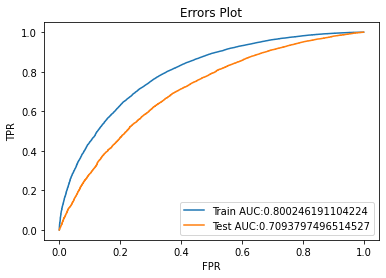

In [ ]:
train_fpr,train_tpr,threshold = roc_curve(y_train,y_train_tfidf_proba)
test_fpr,test_tpr,threshold = roc_curve(y_test,y_test_tfidf_proba)
plt.plot(train_fpr,train_tpr,label='Train AUC:'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test AUC:'+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.title('Errors Plot')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
tfidf_test_score = auc(test_fpr,test_tpr)
tfidf_test_score

0.7093797496514527

In [ ]:
y_train_pred = best_model.predict(X_tr_tfidf)
y_test_pred = best_model.predict(X_te_tfidf)

Text(33.0, 0.5, 'Actual')

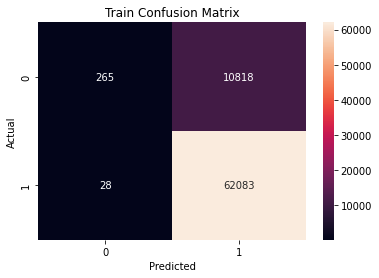

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.title("Train Confusion Matrix")
cm_train_tfidf=confusion_matrix(y_train,y_train_pred)
sns.heatmap(cm_train_tfidf,annot=True,fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

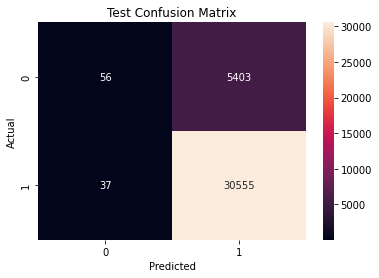

In [ ]:
#confusion matrix of test data
cm_test_tfidf=confusion_matrix(y_test,y_test_pred)
plt.title("Test Confusion Matrix")
sns.heatmap(cm_test_tfidf,annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Set-2

In [ ]:
X_train_tfidf_w2v_essay = coo_matrix(X_train_tfidf_w2v_essay)
X_train_tfidf_w2v_proj_title = coo_matrix(X_train_tfidf_w2v_proj_title)
X_test_tfidf_w2v_essay=coo_matrix(X_test_tfidf_w2v_essay)
X_test_tfidf_w2v_proj_title=coo_matrix(X_test_tfidf_w2v_proj_title)

In [ ]:
X_tr_tfidf_w2v = hstack((X_train_tfidf_w2v_essay,X_train_tfidf_w2v_proj_title,X_train_tp_class0,X_train_tp_class1,X_train_ss_class0,X_train_ss_class1,X_train_prjgc_class0,X_train_prjgc_class1,X_train_prjsc_class0,X_train_prjsc_class1,X_train_prjsubcat_class0,X_train_prjsubcat_class1,X_train_price,X_train_quantity,X_train_teacher_ppp)).tocsr()
X_te_tfidf_w2v = hstack((X_test_tfidf_w2v_essay,X_test_tfidf_w2v_proj_title,X_test_tp_class0,X_test_tp_class1,X_test_ss_class0,X_test_ss_class1,X_test_prjgc_class0,X_test_prjgc_class1,X_test_prjsc_class0,X_test_prjsc_class1,X_test_prjsubcat_class0,X_test_prjsubcat_class1,X_test_price,X_test_quantity,X_test_teacher_ppp)).tocsr()

In [ ]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
'learning_rate' : [0.0001, 0.001, 0.01, 0.1]
}

In [ ]:
xgbclf = lgbm.LGBMClassifier()
clf = GridSearchCV(xgbclf,params,cv=3,scoring='roc_auc',verbose=3,return_train_score=True)
clf.fit(X_tr_tfidf_w2v,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] learning_rate=0.0001, n_estimators=100 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0001, n_estimators=100, score=(train=0.646, test=0.608), total=  39.3s
[CV] learning_rate=0.0001, n_estimators=100 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.5s remaining:    0.0s


[CV]  learning_rate=0.0001, n_estimators=100, score=(train=0.628, test=0.613), total=  37.1s
[CV] learning_rate=0.0001, n_estimators=100 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.0001, n_estimators=100, score=(train=0.638, test=0.598), total=  39.0s
[CV] learning_rate=0.0001, n_estimators=200 ..........................
[CV]  learning_rate=0.0001, n_estimators=200, score=(train=0.654, test=0.615), total= 1.2min
[CV] learning_rate=0.0001, n_estimators=200 ..........................
[CV]  learning_rate=0.0001, n_estimators=200, score=(train=0.631, test=0.614), total= 1.1min
[CV] learning_rate=0.0001, n_estimators=200 ..........................
[CV]  learning_rate=0.0001, n_estimators=200, score=(train=0.639, test=0.599), total= 1.2min
[CV] learning_rate=0.0001, n_estimators=300 ..........................
[CV]  learning_rate=0.0001, n_estimators=300, score=(train=0.657, test=0.617), total= 1.7min
[CV] learning_rate=0.0001, n_estimators=300 ..........................
[CV]  learning_rate=0.0001, n_estimators=300, score=(train=0.635, test=0.615), total= 1.6min
[CV] learning_rate=0.0001, n_estimators=300 ..........................
[CV]  learning_r

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 95.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                        

In [ ]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,38.355094,0.967452,0.111281,0.007000,0.0001,100,"{'learning_rate': 0.0001, 'n_estimators': 100}",0.608369,0.612839,0.598163,0.606457,0.006142,20,0.646049,0.628470,0.638352,0.637624,0.007195
1,69.537685,2.242910,0.160526,0.011572,0.0001,200,"{'learning_rate': 0.0001, 'n_estimators': 200}",0.614563,0.613773,0.598712,0.609016,0.007293,19,0.653609,0.631421,0.639228,0.641419,0.009190
2,100.040290,3.133594,0.214049,0.009814,0.0001,300,"{'learning_rate': 0.0001, 'n_estimators': 300}",0.617057,0.615305,0.598915,0.610426,0.008171,18,0.657310,0.634523,0.641382,0.644405,0.009545
3,131.535212,3.374049,0.272893,0.016679,0.0001,400,"{'learning_rate': 0.0001, 'n_estimators': 400}",0.618272,0.620371,0.601518,0.613387,0.008436,17,0.658951,0.642955,0.645022,0.648976,0.007104
4,161.620995,4.100633,0.342933,0.008036,0.0001,500,"{'learning_rate': 0.0001, 'n_estimators': 500}",0.619663,0.623126,0.604605,0.615798,0.008040,16,0.660249,0.647566,0.650062,0.652626,0.005486


In [ ]:
best_params_2 = clf.best_params_
best_params_2

{'learning_rate': 0.01, 'n_estimators': 500}

In [ ]:
p,q = [],[]
for i in results.params:
    p.append(i['learning_rate'])
    q.append(i['n_estimators'])

In [ ]:
x1=p
y1=q
z1=list(results['mean_train_score'])

x2=p
y2=q
z2=list(results['mean_test_score'])

In [ ]:
Trace1 = go.Scatter3d(x=x1,y=y1,z=z1,name='Train')
Trace2 = go.Scatter3d(x=x2,y=y2,z=z2,name='Test')
plot_data = [Trace1,Trace2]

In [ ]:
layout = go.Layout(scene=dict(
    xaxis=dict(title='learning_rate'),
    yaxis=dict(title='n_estimators'),
    zaxis=dict(title='AUC_Score')))

In [ ]:
fig = go.Figure(plot_data,layout)
fig.show(renderer='colab')

In [ ]:
best_model = lgbm.LGBMClassifier(learning_rate = best_params_2['learning_rate'],n_estimators=best_params_2['n_estimators'],use_label_encoder=False)
best_model.fit(X_tr_tfidf_w2v,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               use_label_encoder=False)

In [ ]:
y_train_tfidf_proba = (best_model.predict_proba(X_tr_tfidf_w2v))[:,1]
y_test_tfidf_proba = (best_model.predict_proba(X_te_tfidf_w2v))[:,1]

Text(0, 0.5, 'TPR')

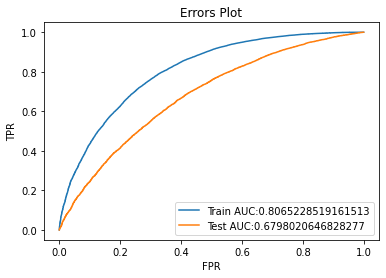

In [ ]:
train_fpr,train_tpr,threshold = roc_curve(y_train,y_train_tfidf_proba)
test_fpr,test_tpr,threshold = roc_curve(y_test,y_test_tfidf_proba)
plt.plot(train_fpr,train_tpr,label='Train AUC:'+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label='Test AUC:'+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.title('Errors Plot')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
tfidf_w2v_test_score = auc(test_fpr,test_tpr)
tfidf_w2v_test_score

0.6798020646828277

In [ ]:
y_train_pred = best_model.predict(X_tr_tfidf_w2v)
y_test_pred = best_model.predict(X_te_tfidf_w2v)

Text(33.0, 0.5, 'Actual')

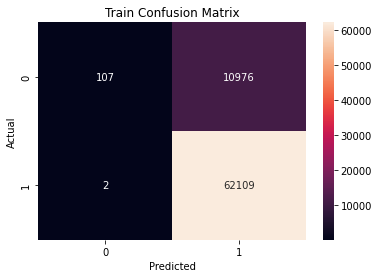

In [ ]:
plt.title("Train Confusion Matrix")
cm_train_tfidf=confusion_matrix(y_train,y_train_pred)
sns.heatmap(cm_train_tfidf,annot=True,fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

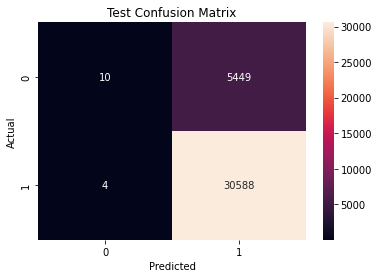

In [ ]:
#confusion matrix of test data
cm_test_tfidf=confusion_matrix(y_test,y_test_pred)
plt.title("Test Confusion Matrix")
sns.heatmap(cm_test_tfidf,annot=True,fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [ ]:
from prettytable import PrettyTable

table = PrettyTable(['Vectorizer','Model','Hyper Parameter','AUC'])
table.add_row(['TFIDF','GBDT',best_params,tfidf_test_score])
table.add_row(['TFIDF-W2V','GBDT',best_params_2,tfidf_w2v_test_score])
print(table)

+------------+-------+----------------------------------------------+--------------------+
| Vectorizer | Model |               Hyper Parameter                |        AUC         |
+------------+-------+----------------------------------------------+--------------------+
|   TFIDF    |  GBDT | {'learning_rate': 0.01, 'n_estimators': 500} | 0.7093797496514527 |
| TFIDF-W2V  |  GBDT | {'learning_rate': 0.01, 'n_estimators': 500} | 0.6798020646828277 |
+------------+-------+----------------------------------------------+--------------------+
